<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Thymio-Project" data-toc-modified-id="Thymio-Project-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Thymio Project</a></span></li><li><span><a href="#Complete-Program" data-toc-modified-id="Complete-Program-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Complete Program</a></span><ul class="toc-item"><li><span><a href="#Thymio-preparation" data-toc-modified-id="Thymio-preparation-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Thymio preparation</a></span></li><li><span><a href="#Imports" data-toc-modified-id="Imports-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#define-the-state-machine" data-toc-modified-id="define-the-state-machine-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>define the state machine</a></span><ul class="toc-item"><li><span><a href="#define-the-Robot-object" data-toc-modified-id="define-the-Robot-object-2.3.1"><span class="toc-item-num">2.3.1&nbsp;&nbsp;</span>define the Robot object</a></span></li><li><span><a href="#Define-the-statefunctions" data-toc-modified-id="Define-the-statefunctions-2.3.2"><span class="toc-item-num">2.3.2&nbsp;&nbsp;</span>Define the statefunctions</a></span></li></ul></li><li><span><a href="#......" data-toc-modified-id="......-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>......</a></span></li><li><span><a href="#adsadaa" data-toc-modified-id="adsadaa-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>adsadaa</a></span></li></ul></li><li><span><a href="#........" data-toc-modified-id="........-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>........</a></span></li><li><span><a href="#Path-planning" data-toc-modified-id="Path-planning-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Path planning</a></span><ul class="toc-item"><li><span><a href="#Initialise-path-planner" data-toc-modified-id="Initialise-path-planner-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Initialise path planner</a></span></li><li><span><a href="#Planning-phase" data-toc-modified-id="Planning-phase-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Planning phase</a></span></li><li><span><a href="#Query-Phase" data-toc-modified-id="Query-Phase-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Query Phase</a></span></li><li><span><a href="#Getting-the-path" data-toc-modified-id="Getting-the-path-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>Getting the path</a></span></li><li><span><a href="#complete-pathplanning-demonstration" data-toc-modified-id="complete-pathplanning-demonstration-4.5"><span class="toc-item-num">4.5&nbsp;&nbsp;</span>complete pathplanning demonstration</a></span></li></ul></li></ul></div>

# Thymio Project







In [ ]:
pip install pyserial

# Complete Program


In this section  the main execution of the program is presented and available to be executed with a thymio that is properly prepared. 
## Thymio preparation
The thymio should have 2 blue dots on it. 1 big, where the wheels are and 1 smaller on the front part. Those dots should be on a light blocking paper which is then mounted on the thymio. Furthermore there are some lights that can't be turned off. These should also be covered as well as possible.


<img src="documentation/ImagesForDocumentation/"
     alt="Thymio Preparation"
     style="float: left; margin-right: 10px;" />
Image showing the top and side cover points
<img src="documentation/ImagesForDocumentation/thymioBottom.jpg"
     alt="Thymio Preparation"
     style="float: left; margin-right: 10px;" />


Image showing the bottom spots to cover
<img src="documentation/ImagesForDocumentation/thymioBehind.jpg"
     alt="Thymio Preparation"
     style="float: left; margin-right: 10px;" />


Image showing the behind spots to cover

If all these spots are covered it wont confuse the vision system.

The main program consists out of three parts. One that takes data  from the different senors present. These are the camera, the horizontal facing infrared distance sensors and the internal speed measurement. These are then processed into the position and orientation of the robot and preprocessed to be able to make desicions in the second part. The second part is the state machine that takes the preprocessed data from the sensor part and decides whether it should 

## Imports
Import all the libraries needed to run the main program

In [1]:
#import standart libraries
import os
import sys
import time
import serial
import numpy as np
from numpy import linalg as LNG 
import math
import cv2
import matplotlib.pyplot as plt
from matplotlib import colors
from PIL import Image
from skimage import exposure

#%matplotlib inline

# Adding the src folder in the current directory as it contains the script
# with the Thymio class and all the files with the group generated functions and classes
sys.path.insert(0, os.path.join(os.getcwd(), 'src'))
from Thymio import Thymio
#import functions made by group
from pathPlanning import pathPlaning
import ANN
import robot_control
import Vision
import sys
from timeit import default_timer as timer
from kalman_filter import kalman_filt

## define the state machine
In this section the different states are defined as in the state machine graph shown earlier. The functions in this sections are named like the states they represent and they wrap the functions imported from the pathPlanning.py, test_vision.py,ANN.py and robot_control.py. 

### define the Robot object
This object contains all the variables needed in the state machine to make decisions.

In [2]:
class stateNames_t:
    def __init__(self):
        self.planAcquired='planAcquired'
        self.newPath='newpath'
        self.checkingPath='checkingPath'
        self.underWay='underWay'
        self.obstacleAvoidance='obstalceAvoidance'
        self.goalReached='goalReached'
class FSMHelper:
    def __init__(self,thymio,equalTolerance,wayPointDistance,pathplanner):
        self.wasKidnapped=False
        self.tolerance=equalTolerance
        self.currentPosition=np.zeros((2,1))
        self.pathPlanner=pathplanner
        self.newPositionEstimate=0    
        self.thymio=thymio      
        self.obstacleDetected=False
        self.doStop=False
        self.goalReached=False
        self.goal=np.zeros((2,1))
        self.pathToFollow=np.array([[0],[0]])
        self.FSMStates=stateNames_t()
        self.straightenedImage=0
        self.wayPointReachedDistance=wayPointDistance
        self.followPath=False
        

### Define the statefunctions
In this section the different functions used to represent the states of the state machine are defined. Each function takes the FSMHelper object to make the decisions which state is the next.

In [3]:
def planAcquired(robot):
    if(robot.wasKidnapped==True):
        robot.pathPlanner.setStart(robot.currentPosition[0:2])
        return robot.FSMStates.newPath
    else:
        return robot.FSMStates.checkingPath
def newPath(robot):#pathPlanner,pathToFollow
    robot.pathToFollow=robot.pathPlanner.getOptimizedPath()
    print("path after Planner",robot.pathToFollow)
    return robot.FSMStates.checkingPath
    
def checkingPath(robot):
    #print("Size",np.size(robot.pathToFollow))
    if(np.size(robot.pathToFollow)!=0):
        #print("path:",robot.pathToFollow)
        robot.followPath=True
        return robot.FSMStates.underWay
    else:
        robot.followPath=False
        robot.doStop=True
        return robot.FSMStates.goalReached
def underWay(robot):
    if(robot.obstacleDetected==True):
        robot.followPath=False
        return robot.FSMStates.obstacleAvoidance
    else:
        return robot.FSMStates.planAcquired
def avoidObstacle(robot):     
    ANN.run_ann_without_memory(robot.thymio)
    return robot.FSMStates.checkingPath 
def goalReached(robot):
    robot.goalReached=True
    
    
#define the concrete stateName object to make the dictionary for the actual state machine
stateName=stateNames_t()
switch = {
    stateName.planAcquired     : planAcquired,
    stateName.newPath          : newPath,
    stateName.checkingPath     : checkingPath,
    stateName.underWay         : underWay,
    stateName.obstacleAvoidance: avoidObstacle,
    stateName.goalReached      : goalReached,
}
currentState=stateName.planAcquired
futureState=stateName.planAcquired

#possible struckture of main code chapter
show state event diagramm


## ......
The first steps are to try to connect to the camera and the thymio and then set different decision variables

## adsadaa
In this section the vision part is used to generate a map and then define a pathfinding object for that map. These section represents the 3 first states, since that division can be done in a Notebook

In [4]:
th=Thymio.serial(port="COM6", refreshing_rate=0.1)

In [ ]:

th.set_var_array("leds.top", [0, 0, 0])
th.set_var_array("leds.bottom.right", [0, 0, 0])
th.set_var_array("leds.bottom.left", [0, 0, 0])


In [5]:
cameraIndex=1             #index 1 is the index of the specific machine used. it is highly likly that it is on other machines aswell
cv2.namedWindow("preview")
videoCapture = cv2.VideoCapture(cameraIndex)
if not(videoCapture.isOpened()):
    raise Exception('could not connect to camera')
videoCapture = cv2.VideoCapture(cameraIndex)
exposureOfCamera=-2.1          #initial exposure
videoCapture.set(cv2.CAP_PROP_EXPOSURE,exposureOfCamera)
videoCapture.set(cv2.CAP_PROP_SATURATION ,120)

if not(videoCapture.isOpened()):
    raise Exception('could not connect to camera')

if videoCapture.isOpened(): # try to get the first frame
    rval, frame = videoCapture.read()
else:
    rval = False
    raise Exception('could not connect to camera')
while rval:
    cv2.imshow("preview", frame)
    rval, frame = videoCapture.read()
    key = cv2.waitKey(20)
    if key == 27: # exit on ESC
        break
    elif(key== ord('w')):
        exposureOfCamera=exposureOfCamera+0.1
        print (videoCapture.set(cv2.CAP_PROP_EXPOSURE,exposureOfCamera),exposureOfCamera)
    elif(key== ord('s')):    
        exposureOfCamera=exposureOfCamera-0.1
        print (videoCapture.set(cv2.CAP_PROP_EXPOSURE,exposureOfCamera),exposureOfCamera)
cv2.destroyWindow("preview")
cv2.destroyAllWindows()

Endpoint Coordinates:  (104.89991635108736, 10.212747982179149)


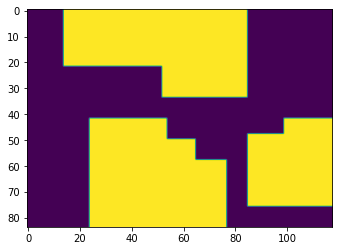

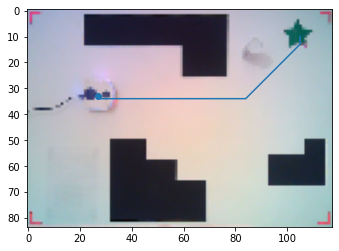

In [9]:
%matplotlib inline
#cv2.namedWindow("preview")
videoCapture.set(cv2.CAP_PROP_EXPOSURE,-2.9)
if videoCapture.isOpened(): # try to get the first frame
    rval, frame = videoCapture.read()
else:
    rval = False
    raise Exception('could not read image!')
#read corner mask
mask= cv2.imread('Images/Mondamask.JPG')
if mask.size==0:
    raise Exception('Could not open Mask')
dimension_paper = [118.9,84.1] #cm A0
dim = (int(dimension_paper[1]),int(dimension_paper[0]))
# Switching red and blue channels
frame[:, :, [0, 2]] = frame[:, :, [2, 0]]
mask[:, :, [0, 2]] = mask[:, :, [2, 0]]
#plt.imshow(frame)

#plt.show()
plt.imsave('maptest.jpg',frame)
#preprocess image data to facilitate map generation and thymio position accusition
p2_1, p98_1 = np.percentile(frame, (2, 98))
img_res1 = exposure.rescale_intensity(frame, in_range=(p2_1,p98_1))
img1_gray = cv2.cvtColor(img_res1, cv2.COLOR_BGR2GRAY)
threshold_bg=130

percent = 0.9
while True:
        output = Vision.bg_clustering(img1_gray, (50,50),threshold_bg)
        corner_location = Vision.corner_detection(output,mask) # Get the location of the 4 corners
        img_straighten, M = Vision.four_point_transform(frame, corner_location) # Get the transformation matrix and the straighten img
        if(img_straighten.shape[0] > output.shape[0]*percent and img_straighten.shape[1] > output.shape[1]*percent):
            break
        else:
            rval, frame = videoCapture.read()
            frame[:, :, [0, 2]] = frame[:, :, [2, 0]]
            print("Retake Picture, Webcame iz noobs") # Command to retake the picture from webcam # Get the transformation matrix and the straighten img

im_dim = img_straighten.shape
obstacles = Vision.get_obstacles(img_straighten) # OFFLINE
thymio_coord = Vision.get_thymio_info(frame,M,dim,im_dim) # Do these online, and feed info to kalman filter
endpoint_coord = Vision.get_endpoint_info(frame,M,dim,im_dim)
low_res_img = cv2.resize(img_straighten, dsize=((dim[1], dim[0])))




occupancyGrid=cv2.resize(obstacles, dsize=(int(dim[1]), int(dim[0])))
occupancyGrid=occupancyGrid>200
occupancyGrid=occupancyGrid.astype(float)
kernel2 = np.ones((7,7), np.uint8)
occupancyGrid = cv2.dilate(occupancyGrid, kernel2, iterations=2)
plt.imshow(occupancyGrid)
plt.show()
#plt.imshow(occupancyGrid)
pathPlanner=pathPlaning(occupancyGrid.copy(),1,1)
#give over the thymio connection,set the kidnapping distance to 10 and the tolerance for equality to 1e-6, the distance when it is considered way point reached
robotStatus=FSMHelper(th,1e-6,0.5,pathPlanner)
robot_control.th=th
#print(np.asarray(endpoint_coord))
robotStatus.pathPlanner.setGoal(np.asarray(endpoint_coord))
#print(np.asarray(thymio_coord[0]))
robotStatus.currentPosition=np.array([(thymio_coord[0][0]),(thymio_coord[0][1]),(thymio_coord[1])/180*np.pi])
#print(robotStatus.currentPosition[0:2])
robotStatus.pathPlanner.setStart(robotStatus.currentPosition[0:2])
robotStatus.pathToFollow=robotStatus.pathPlanner.getOptimizedPath()
estimatedRobotPose=robotStatus.currentPosition

#show path on image
originalPath=robotStatus.pathToFollow.copy() 

plt.imshow(low_res_img)
plt.scatter(thymio_coord[0][0],thymio_coord[0][1])
plt.plot(originalPath[0],originalPath[1])
plt.show()

---------------------------------------------------------WAYPOINT REACHED
---------------------------------------------------------WAYPOINT REACHED
---------------------------------------------------------WAYPOINT REACHED
---------------------------------------------------------WAYPOINT REACHED
---------------------------------------------------------WAYPOINT REACHED
GOAL REACHED


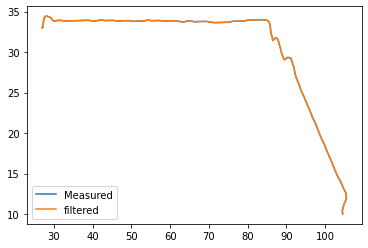

In [10]:
%matplotlib qt
#constant kalman matrixes
"""
A = np.array([[1,0,0],[0,1,0],[0,0,1]])
C = np.array([[0,0,0],[0,0,0],[0,0,0]])
Q = np.array([[5, 0, 0],[0, 5, 0],[0,0,5]]) # Dependent on the error (can be linked to stated as velocity, but velocity is not taken as state. )
R = np.array([[0.01,0,0],[0,0.01,0],[0,0,0.01]])
Q_ini = Q
X = np.array([[estimatedRobotPose[0]],[estimatedRobotPose[1]],[estimatedRobotPose[2]]], dtype = "float32")
print(X.size)
L = []
"""
timeElapsed=np.array([0,0], dtype = 'float64')
#print("robotstartPose",robotStatus.currentPosition)
robotPositionUncertainty=np.zeros((3,3))
#print(robotStatus.pathToFollow)
currentState=stateName.planAcquired
futureState=stateName.planAcquired
originalPath=robotStatus.pathToFollow.copy()    #times 2 becuase the vision system operates at 0.5 cm per pixel and the pathfinding at 1 cm per pixel
doPlotCounter=0
deltaT=0.0
tbefore=time.time()
tnow=0
unfilteredCoordinates=list()
filteredCoordinates=list()
cutOfDistance=5
cameraDataStableCounter=0
cameraEstimate=robotStatus.currentPosition
cameraData=True
numberOfStableMeasurments=10
while(True):         #main execution loop
    ##read sensors    
    #----get robot position from camera
    [frameCaptureSuccesfull,newPicture]=videoCapture.read()
    if(frameCaptureSuccesfull==False):
        raise Exception('could not read from camera')
    newPicture[:, :, [0, 2]] = newPicture[:, :, [2, 0]]
    thymio_coord = Vision.get_thymio_info(newPicture,M,dim,im_dim) # Do these online, and feed info to kalman filter
    ###---------------camera data true
    if(cameraData==True):
        newCameraEstimate=np.array([thymio_coord[0][0],thymio_coord[0][1],thymio_coord[1]/180.0*np.pi])
        unfilteredCoordinates.append((cameraEstimate[0],cameraEstimate[1]))
        
        if(LNG.norm(newCameraEstimate[0:2]-cameraEstimate[0:2])<cutOfDistance):
            cameraDataStableCounter=cameraDataStableCounter+1
            
            
        else:
            cameraDataStableCounter=0
        cameraEstimate=newCameraEstimate
   
    #print("cameraEstimate",cameraEstimate,"ThymioCoordinate",thymio_coord)   
    #print("CurrentPosition",robotStatus.currentPosition)
    #-----get odometrie data
    #print("before odometry",robotStatus.currentPosition)
    estimatedRobotPose,robotPositionUncertainty,timeElapsed=robot_control.odometry(robotStatus.currentPosition,robotPositionUncertainty,timeElapsed, robot_control.MAX_SPEED)
    """plt.scatter(estimatedRobotPose[0],estimatedRobotPose[1])
    plt.show()"""
    """
    V_left=th["motor.left.speed"]*0.0135
    V_right=th["motor.right.speed"]*0.0135
    v_avg = (V_left + V_right)/2
    v_delta = V_left- V_right
    """
    #-----estimate current robot position
    tnow=time.time()
    deltaT=tnow-tbefore
    #print("deltaT",deltaT)
    tbefore=tnow
    """
    B = np.array([[(math.cos(cameraEstimate[2])),0.], [(math.sin(cameraEstimate[2])), 0.], [0.,1.]])
    Z = np.array([[cameraEstimate[0]],[cameraEstimate[1]],[cameraEstimate[2]]], dtype = "float32")
    u = np.array([[v_avg*deltaT],[v_delta*deltaT]])
    """
    #print(u)
    #thymio_position,cov = kalman_filt(X,u,Q_ini,Z,A,B,C,Q,R)
    
    #X = thymio_position
    #Q_ini = cov
    """#data accusition
    print("Camera Estimate:",cameraEstimate)
    print("leftmotor:",th["motor.left.speed"])
    print("rightmotor:",th["motor.right.speed"])
    
    """
    #if(cameraDataStableCounter>numberOfStableMeasurments):
        #print(cameraDataStableCounter)
    if(cameraData==True and (LNG.norm(estimatedRobotPose[0:2]-cameraEstimate[0:2])<cutOfDistance or cameraDataStableCounter>numberOfStableMeasurments)):
        robotStatus.currentPosition=cameraEstimate
    else:
        robotStatus.currentPosition=estimatedRobotPose #np.transpose(X).flatten()
    filteredCoordinates.append((robotStatus.currentPosition[0],robotStatus.currentPosition[1]))
    #print("stuff",robotStatus.newPositionEstimate)
    #------------check if unexcpected obstacle is present
    robotStatus.obstacleDetected=not(all(sensorValues==0 for sensorValues in robotStatus.thymio["prox.horizontal"]))
    #print("ObstacleDetected",robotStatus.obstacleDetected)
    #if(cameraData==True):
        #robotStatus.currentPosition
   
    
    
    #------------------------------make desicions and work with the collected data 
    
    
    
    stateToExecute=switch.get(currentState)
    #print(currentState)
    futureState=stateToExecute(robotStatus)
    
    #doRobotControl here
    #_,robotStatus.pathToFollow=robot_control.path_following(robotStatus.currentPosition, robotStatus.pathToFollow, THREASHOLD = 0.5)
    
    #stopping robot if goal reached end programm
    if(robotStatus.followPath==True and np.size(robotStatus.pathToFollow)!=0):
        _,robotStatus.pathToFollow=robot_control.path_following(robotStatus.currentPosition,robotStatus.pathToFollow)
    if(robotStatus.doStop==True):
        robotStatus.thymio.set_var("motor.left.target", 0)
        robotStatus.thymio.set_var("motor.right.target", 0)
    if(robotStatus.goalReached==True):
        robotStatus.thymio.set_var("motor.left.target", 0)
        robotStatus.thymio.set_var("motor.right.target", 0)
        break
    currentState=futureState
    doPlotCounter=doPlotCounter+1
    if(doPlotCounter>10 or robotStatus.goalReached==True):
        doPlotCounter=0
        low_res_img = cv2.resize(newPicture, dsize=((dim[1], dim[0])))
        low_res_img[:, :, [0, 2]] = low_res_img[:, :, [2, 0]]
        low_res_img = cv2.circle(low_res_img, (int(robotStatus.currentPosition[0]),int(robotStatus.currentPosition[1])), radius=2, color=(0, 0, 255), thickness=-1)
        cv2.circle(low_res_img, (int(cameraEstimate[0]),int(cameraEstimate[1])), radius=10, color=(0, 255, 0), thickness=2)
        cv2.circle(low_res_img, (int(estimatedRobotPose[0]),int(estimatedRobotPose[1])), radius=8, color=(255, 0, 0), thickness=2)
        cv2.circle(low_res_img, (int(robotStatus.currentPosition[0]),int(robotStatus.currentPosition[1])), radius=16, color=(255, 0, 0), thickness=2)
        cv2.imshow("Display window",low_res_img)
        if(robotStatus.goalReached):
            cv2.waitKey(0)
        else:
            cv2.waitKey(1)
        #plt.scatter(thymio_coord[0][0],thymio_coord[0][1])
        #plt.plot(originalPath[0],originalPath[1])
        #print("odometrie estimate",estimatedRobotPose)
        #plt.scatter(estimatedRobotPose[0],estimatedRobotPose[1])
        #plt.show()
unfilteredCoordinates=np.array(unfilteredCoordinates).reshape(-1, 2).transpose()
filteredCoordinates=np.array(filteredCoordinates).reshape(-1, 2).transpose()
plt.plot(unfilteredCoordinates[0],unfilteredCoordinates[1],label="Measured")
plt.plot(filteredCoordinates[0],filteredCoordinates[1],label="filtered")
plt.legend()
plt.show()
cv2.destroyAllWindows() 
cv2.VideoCapture(cameraIndex).release()

In [ ]:
cv2.destroyAllWindows() 
cv2.VideoCapture(cameraIndex).release()

In [ ]:
th.set_var("motor.left.target", 00)
th.set_var("motor.right.target",00)
#ANN.run_ann_without_memory(th)


# ........



# Path planning

After having generated the map inside the computer with vision pathplanning is needed to create a path from the starting point to the goal. This is made possible by the pathplanning class.
This class is used to create a pathplanning object, which is linked to a specific map, on which then all pathplanning is done.

## Initialise path planner
To create the object the constructor of the class needs 3 things, The occupancy grid in form of a numpy array, with which number the occupied cells are marked and many CM represents one pixel(cell)

In [ ]:
#imports needed to run pathplanning
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from PIL import Image
import sys
import time
from timeit import default_timer as timer

#import pathplanning class
sys.path.insert(0, os.path.join(os.getcwd(), 'src'))
from pathPlanning import pathPlaning

#load a testing map from image and convert it into a numpy array 
#(based on: https://www.pluralsight.com/guides/importing-image-data-into-numpy-arrays)
pil_imgray = Image.open('Images/obstaclesTestMap.jpg').convert('LA')
img = np.array(list(pil_imgray.getdata(band=0)), float)
img.shape = (pil_imgray.size[1], pil_imgray.size[0])
img=img<200
occupancyGrid=img.astype(int)
plt.imshow(occupancyGrid)
##generate pathplanning object for the occupancy grid generated by the testmap
pathPlanner=pathPlaning(occupancyGrid.copy(),1,1)#occipied cells are marked with a 1 and 1 cm per pixel

## Planning phase
Now that the pathplanning object has a map on which it should plan paths, the goal needs to be set by calling the "setGoal" method of the object and hand over a numpy array with the x,y coordinates of the goal.\[x,y\]. These coordinates are in cm.

In [ ]:
startTimer=timer()    #execution time when goal is set once
#set goal
goal=np.array([90,15])
pathPlanner.setGoal(goal)

endTimer=timer()
print("Time needed for planning goal:",endTimer-startTimer)

startTimer=timer()    #execution time when goal is set again
#set goal
goal=np.array([90,15])
pathPlanner.setGoal(goal)

endTimer=timer()
print("Time needed for planning for the same goal again:",endTimer-startTimer)

When the "setGoal" method is called it simultaneously starts the planning phase. This does not mean that a path is planned but that the map is prepared to do fast pathplanning for each starting point one can come up with. This means that if the goal is often changed it will be a lot slower than a A*-pathplanner. If the goal stays the same and just the starting point changes often, it will be quite a bit faster. This is because in this planning phase, which is encapsulated in the private method \_\_generateGradient. In it a map is created, where for each grid cell its distance to the goal is calculated. This distance is a path distance, so the value saved means from the current cell you the robot has to move so many cells to reach the goal. This calculation is started from the goal and is made for every cell that is not marked occupied. The result is saved in the private distanceMap attribute, which can be accessed by a getter method "getDistanceMap". The occupied cells are left at the starting value of 0. This means during path generation the map needs to be checked whether the cell is occupied or not. But it also means that to make a path the path generator just has to "roll" down hill.

In [ ]:
#make the distance map visible
distanceGrid=pathPlanner.getDistanceMap()
fillUp=np.zeros_like(occupancyGrid)#helper to make picture 3 colors
maxValue=np.amax(distanceGrid.transpose())   # normalize values to fit into picture
#create picture to show  map and distance map
pic=np.dstack((occupancyGrid,np.divide(distanceGrid,maxValue),fillUp))
plt.imshow(pic)
plt.scatter(goal[0],goal[1],marker="o", color = 'yellow',s=200)
plt.xlabel('X-direction')
plt.ylabel('Y-direction')
plt.show()

In this picture,in red are the obstacles, in yellow the goal and in green the distance of the pixel to the goal in terms of how much movement would be needed to get to the goal.
As can be seen surrounding the goal(the yellow point) are dark areas. This means those cells are very close to the goal. The greener the pixel is the longer the movement required to get to the goal from this pixel(cell). As can be seen if the goal is (90,15)(x,y) in the corner bottom left. There you can see a darker diagonal. This means if the robot is on those cells he needs to move less than if he is positioned at (80,20) 

## Query Phase
Now that the planning phase is over, the pathplanner is ready to provide paths to the goal from every free cell. To start the query phase and actually plan a path the start point needs to be provided. When the start point is provided, the class calls the private method "\_\_generatePath" to generate the path from the defined start point to the defined goal. For this the method begins at the starting point and looks for the cell, which has the smallest distance to goal of all its neighbors and puts the coordinates of that cell into the path. Of course only cells which are marked as free in the occupancy grid are checked. This goes on until th goal is reached. It is a bi comparable to rolling down a hill, since the cell from where the longest path to the goal exists is at the top of the hill.
But this is only possible if "setGoal" was called atleast once before! Otherwise it can not find a path.

In [ ]:
startTimer=timer()
start=np.array([10,75])
pathPlanner.setStart(start)
endTimer=timer()
print("Time needed for the query for a new path:",endTimer-startTimer)

As may have been noticeable the query phase of the pathplanning is very fast.

## Getting the path
Now that both planning and query phases are complete, the path can be extracted by calling the method "getPath" or "getOptimizedPath" The "getPath" method returns the path as a numpy array with the first line representing the x-coordinates and the second line representing the y coordinates.

In [ ]:
unoptimizedPath=pathPlanner.getPath()
print(unoptimizedPath)

The "getoptimizedPath" method returns a path where only the points, where the robot needs to turn, are retained. The path is output in the same format as the path from "getPath"

In [ ]:
optimizedPath=pathPlanner.getOptimizedPath()
print(optimizedPath)

And now the 2 paths drawn onto the map

In [ ]:
plt.imshow(occupancyGrid)
plt.plot(unoptimizedPath[0], unoptimizedPath[1], marker="o", color = 'blue');
plt.scatter(optimizedPath[0],optimizedPath[1], marker="o", color = 'cyan',s=150)
plt.xlabel('X-direction')
plt.ylabel('Y-direction')
plt.show()

The cyan dots represent the optimized path and the blue dots represent the unoptimized path. As can be seen for the optimized path only the waypoints where the robot needs to change its orientation, are retained.

## complete pathplanning demonstration
To see the complete Pathplanning on the testing map inaction this section can be run. To get a explanation of each part, see in the previous chapters

In [ ]:
#imports needed to run pathplanning
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from PIL import Image
import sys
import time
from timeit import default_timer as timer

#import pathplanning class
sys.path.insert(0, os.path.join(os.getcwd(), 'src'))
from pathPlanning import pathPlaning

#load a testing map from image and convert it into a numpy array 
#(based on: https://www.pluralsight.com/guides/importing-image-data-into-numpy-arrays)
pil_imgray = Image.open('Images/obstaclesTestMap.jpg').convert('LA')
img = np.array(list(pil_imgray.getdata(band=0)), float)
img.shape = (pil_imgray.size[1], pil_imgray.size[0])
img=img<200
occupancyGrid=img.astype(int)
plt.imshow(occupancyGrid)
##generate pathplanning object for the occupancy grid generated by the testmap
pathPlanner=pathPlaning(occupancyGrid.copy(),1,1)#occipied cells are marked with a 1 and 1 cm per pixel

#--set goal
startTimer=timer()    #execution time when goal is set once
#set goal
goal=np.array([90,15])
pathPlanner.setGoal(goal)

endTimer=timer()
print("Time needed for planning goal:",endTimer-startTimer)
#---set path
startTimer=timer()
start=np.array([10,75])
pathPlanner.setStart(start)
endTimer=timer()
print("Time needed for the query for a new path:",endTimer-startTimer)

#--- get unoptimized path
unoptimizedPath=pathPlanner.getPath()
#-- get optimized Path
optimizedPath=pathPlanner.getOptimizedPath()
#--- draw all the components onto the same picture

#make the distance map visible
distanceGrid=pathPlanner.getDistanceMap()
fillUp=np.zeros_like(occupancyGrid)#helper to make picture 3 colors
maxValue=np.amax(distanceGrid.transpose())   # normalize values to fit into picture
#create picture to show  map and distance map
pic=np.dstack((occupancyGrid,np.divide(distanceGrid,maxValue),fillUp))
plt.imshow(pic)
plt.scatter(goal[0],goal[1],marker="o", color = 'yellow',s=200)
plt.xlabel('X-direction')
plt.ylabel('Y-direction')
plt.plot(unoptimizedPath[0], unoptimizedPath[1], marker="o", color = 'blue');
plt.scatter(optimizedPath[0],optimizedPath[1], marker="o", color = 'cyan',s=150)
plt.show()

The blue points represent the unoptimized path, the cyan points are the optimized paths waypoint and red are the occupied cells. The green shade represents the distance of that pixel(cell) to the goal. The greener the longer is the path to the goal from that pixel(cell)
As can be seen the path follows closely the obstacle. To prevent the robot from colliding with the obstacles, they need to be enlarged in the occupancy grid before the occupancy grid is given to the constructor. To see different behaviors the goal and start can be changed freely.

In [ ]:

lower = np.array([20,50,90])
        upper = np.array([100,100,255])

In [ ]:


import cv2

cv2.namedWindow("preview")
cameraIndex=1             #TODO: change it to the correct camera. currently uses webcam
sat=10
exp=-6
videoCapture = cv2.VideoCapture(cameraIndex)
videoCapture.set(cv2.CAP_PROP_EXPOSURE,-6)
videoCapture.set(cv2.CAP_PROP_SATURATION ,10)
if not(videoCapture.isOpened()):
    raise Exception('could not connect to camera')

if videoCapture.isOpened(): # try to get the first frame
    rval, frame = videoCapture.read()
else:
    rval = False
    print("no image")

while rval:
    cv2.imshow("preview", frame)
    rval, frame = videoCapture.read()
    key = cv2.waitKey(20)
    if key == 27: # exit on ESC
        break
    elif(key== ord('w')):
        exp=exp+0.1
        print (videoCapture.set(cv2.CAP_PROP_EXPOSURE,exp),exp)
    elif(key== ord('s')):    
        exp=exp-0.1
        print (videoCapture.set(cv2.CAP_PROP_EXPOSURE,exp),exp)
cv2.destroyWindow("preview")
cv2.destroyAllWindows() 
cv2.VideoCapture(cameraIndex).release()